# Mash Regressions

Using observational data, build a model of the heating performance of the HERMS system.

This model yields the function:
```time = f(temp, volume)```

Where `temp` is the target temp, `volume` is the total volume and `time` is the time required to reach the target.



In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import os

# Load all data under the mash directory
data_dir = './data/mash/'
frames = []
for data_file in os.listdir(data_dir):
    frames.append(pd.read_csv(data_dir + data_file))

merged_frame = pd.concat(frames, sort=False)

### Raw Datapoints
First we'll scatter plot the data in a couple different ways.  The most "normal" way of expressing this data would be to use `elapsed_time` as the x-axis, for what I'm actually looking to do with this model, it makes more sense for `elapsed_time` be the y-axis.  That is because I really want to calculate a time offset given a target tempature & total volume.

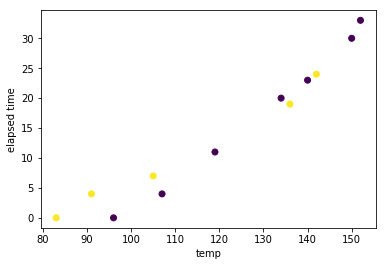

In [17]:
plt.scatter('temp', 'elapsed', c='total_volume', data=merged_frame)
plt.ylabel('elapsed time')
plt.xlabel('temp')
plt.show()

### Multi-Variable OLS

In [62]:
X = merged_frame[["elapsed", "total_volume"]]
y = merged_frame["temp"]
#X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

/Users/speshak/Documents/other_projects/brewery-process-simulator/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     589.6
Date:                Tue, 18 Sep 2018   Prob (F-statistic):           4.21e-11
Time:                        16:38:43   Log-Likelihood:                -46.146
No. Observations:                  12   AIC:                             96.29
Df Residuals:                      10   BIC:                             97.26
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
elapsed          2.3314      0.307      7.606      0.000       1.648       3.014
total_volume     4.2813      0.278     15.391      0.000       3.662       4.901
==============================================================================
Omnibus:                        2.522   Durbin-Watson:                   0.617
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                1.021
Skew:                           0.196   Prob(JB):                        0.600
Kurtosis:                       1.626   Cond. No.                         2.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Solve for `f(temp,vol)`

In [6]:
X = merged_frame[["temp", "total_volume"]]
y = merged_frame["elapsed"]
#X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

/Users/speshak/Documents/other_projects/brewery-process-simulator/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                elapsed   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     79.10
Date:                Fri, 21 Sep 2018   Prob (F-statistic):           7.43e-07
Time:                        10:48:54   Log-Likelihood:                -35.031
No. Observations:                  12   AIC:                             74.06
Df Residuals:                      10   BIC:                             75.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
temp             0.3657      0.048      7.606      0.000       0.259       0.473
total_volume    -1.4624      0.293     -4.992      0.001      -2.115      -0.810
==============================================================================
Omnibus:                        1.943   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.388
Skew:                          -0.677   Prob(JB):                        0.500
Kurtosis:                       2.029   Cond. No.                         26.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Sanity Check Linear Regression

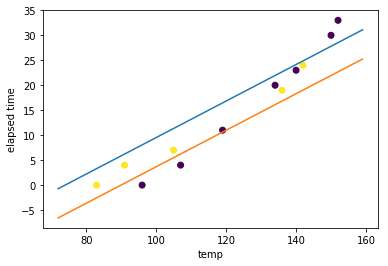

In [45]:
plt.scatter('temp', 'elapsed', c='total_volume', data=merged_frame)
plt.ylabel('elapsed time')
plt.xlabel('temp')
rr = np.arange(72, 160)


def funct(temp, vol):
    return (
        (temp * model.params['temp']) +
        (vol * model.params['total_volume'])
    )

for group in merged_frame.groupby('total_volume').groups:
    plt.plot(rr, funct(rr, group))

plt.show()

### Curved Regression

*WARNING*: This doesn't currently take volume into account.

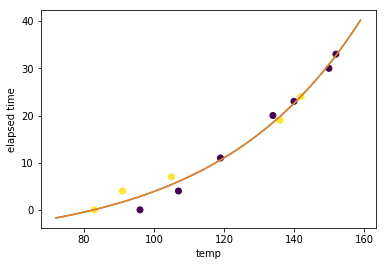

(array([-7.45903954,  1.02459866]), array([[ 6.98923173e-01, -1.74036410e-04],
       [-1.74036410e-04,  6.09742669e-08]]))


In [46]:
def funct(X, a, b):
    return (
        a + b**(X['temp'])
    )

fit = scipy.optimize.curve_fit(
    funct,
    merged_frame[["temp", "total_volume"]],
    merged_frame['elapsed'])

plt.scatter('temp', 'elapsed', c='total_volume', data=merged_frame)
plt.ylabel('elapsed time')
plt.xlabel('temp')
rr = np.arange(72, 160)


for group in merged_frame.groupby('total_volume').groups:
    plt.plot(rr, funct({'temp': rr, 'total_volume': group}, fit[0][0], fit[0][1]))

plt.show()
print(fit)

### Polyfit

In [47]:
fit = np.polyfit(merged_frame[["temp", "total_volume"]], merged_frame['elapsed'], 3)

TypeError: expected 1D vector for x